# Previsão de valores do aluguel de imóveis no município de São Paulo

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import time
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, DBSCAN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter
from matplotlib.ticker import FuncFormatter
from sklearn.decomposition import TruncatedSVD

In [3]:
df = pd.read_csv('/home/botero/Documents/POS/F_machine_learning/projeto/imoveis-sp-prediction/dados/data.csv')

## Análise dos dados

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


In [5]:
df.describe()

,area,bedrooms,garage,rent,total
count,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000
mean,84.655658,1.966286,1.060393,3250.814789,4080.030625
std,74.020536,0.931313,1.132349,2650.711557,3352.480274
min,0.000000,0.000000,0.000000,500.000000,509.000000
25%,40.000000,1.000000,0.000000,1590.000000,1996.000000
50%,60.000000,2.000000,1.000000,2415.000000,3057.000000
75%,96.000000,3.000000,2.000000,3800.000000,4774.000000
max,580.000000,6.000000,6.000000,25000.000000,28700.000000


In [6]:
df.head(50)

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654
5,Rua Domingos Paiva,Brás,50,2,1,Apartamento,3800,4587
6,Rua Guararapes,Brooklin Paulista,72,2,1,Apartamento,3500,5187
7,Avenida Cásper Líbero,Centro,26,1,0,Studio e kitnet,1727,2244
8,Rua José Peres Campelo,Piqueri,32,2,0,Apartamento,1200,1592
9,Rua Guaperuvu,Vila Aricanduva,36,1,0,Apartamento,1200,1501


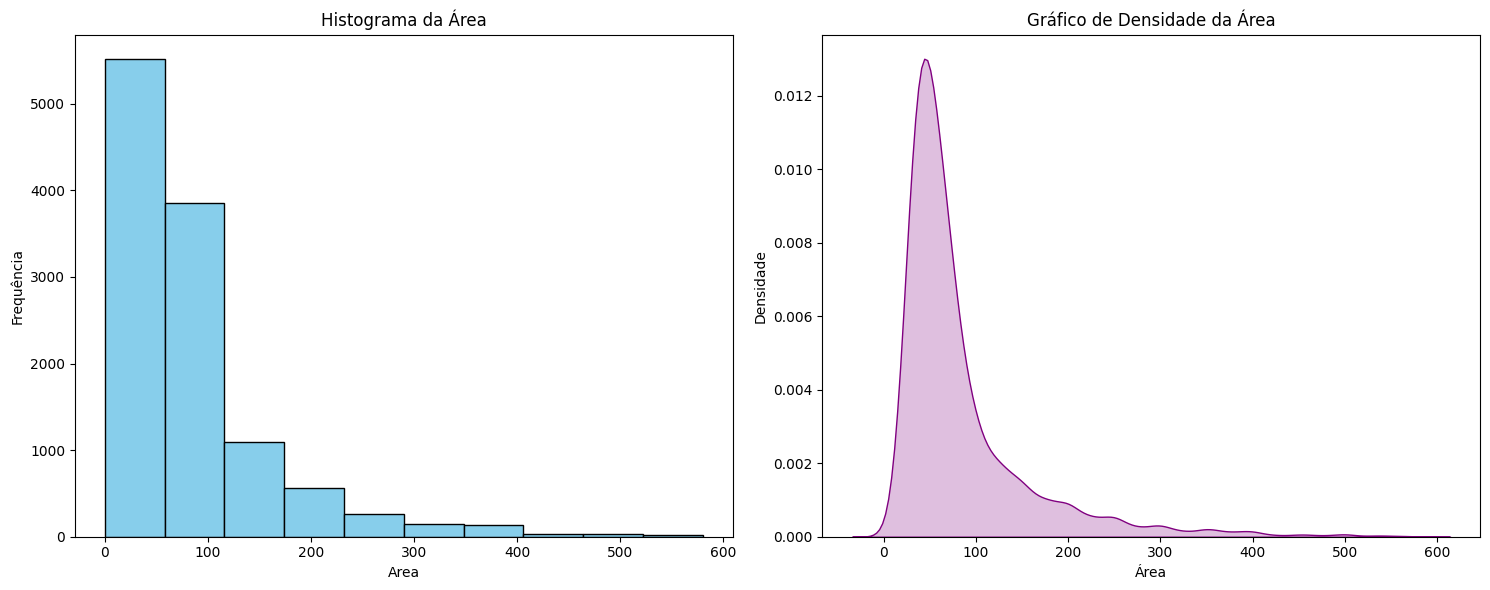

In [7]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histograma (usando Matplotlib)
axes[0].hist(df.area, bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Histograma da Área')
axes[0].set_xlabel('Area')
axes[0].set_ylabel('Frequência')

# Gráfico de Densidade (KDE Plot - usando Seaborn)
sns.kdeplot(data=df, x='area', fill=True, color='purple', ax=axes[1])
axes[1].set_title('Gráfico de Densidade da Área')
axes[1].set_xlabel('Área')
axes[1].set_ylabel('Densidade')

plt.tight_layout()
plt.show()


count    11657.000000
mean        84.655658
std         74.020536
min          0.000000
25%         40.000000
50%         60.000000
75%         96.000000
max        580.000000
Name: area, dtype: float64

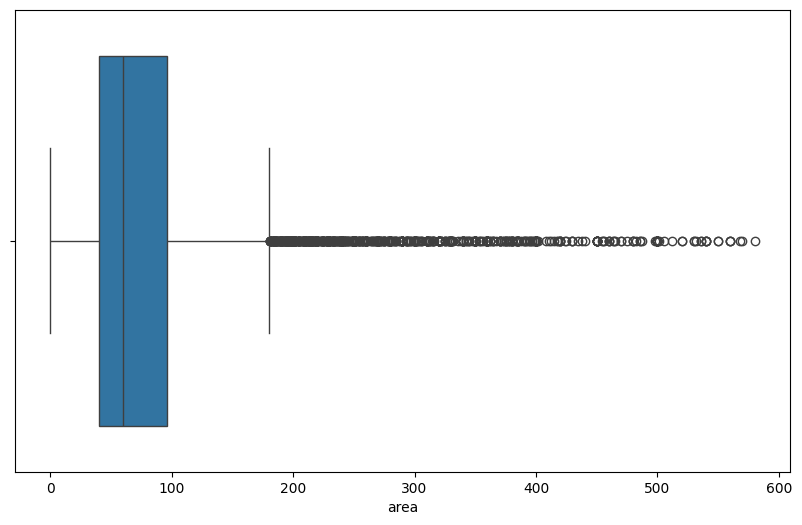

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])
df.area.describe()

### Verificando a area do menor valor de aluguel

In [9]:
df[df.rent == 500]

,address,district,area,bedrooms,garage,type,rent,total
51,Rua Tanque Velho,Vila Nivi,45,1,0,Casa,500,551
1188,Viela Renaldo Laporta,Vila Aurora (zona Norte),30,1,0,Casa,500,521
4741,Rua Manoel Oliveira Gonçalves,Jardim Jaçanã,30,1,0,Casa,500,509
5901,Rua Manuel José Rodrigues,Sacoma,40,1,0,Casa,500,521
6428,Rua Eugênia S Vitale,Taboão,30,1,0,Studio e kitnet,500,594
7420,Rua Manuel José Rodrigues,Sacoma,20,1,0,Casa,500,521
10559,Rua Arraial de São Bartolomeu,Vila Carmosina,70,2,0,Casa,500,821


## Limpeza dos dados


### Tratando os outliers

#### Apagar todos os imóveis cuja área é MENOR do que o valor mais barato de aluguel e MAIOR que 120m2

In [10]:
print(df.iloc[7420])
df = df[df.area >= 20]
df = df[df.area < 120]
df.describe()

address     Rua Manuel José Rodrigues
district                       Sacoma
area                               20
bedrooms                            1
garage                              0
type                             Casa
rent                              500
total                             521
Name: 7420, dtype: object


,area,bedrooms,garage,rent,total
count,9294.000000,9294.000000,9294.000000,9294.000000,9294.000000
mean,56.200237,1.691952,0.719389,2519.761244,3189.729611
std,22.630761,0.704710,0.712388,1672.245840,2070.056269
min,20.000000,0.000000,0.000000,500.000000,509.000000
25%,39.000000,1.000000,0.000000,1460.000000,1824.000000
50%,51.000000,2.000000,1.000000,2100.000000,2683.500000
75%,70.000000,2.000000,1.000000,3000.000000,3943.750000
max,119.000000,5.000000,6.000000,25000.000000,26710.000000


count    9294.000000
mean       56.200237
std        22.630761
min        20.000000
25%        39.000000
50%        51.000000
75%        70.000000
max       119.000000
Name: area, dtype: float64

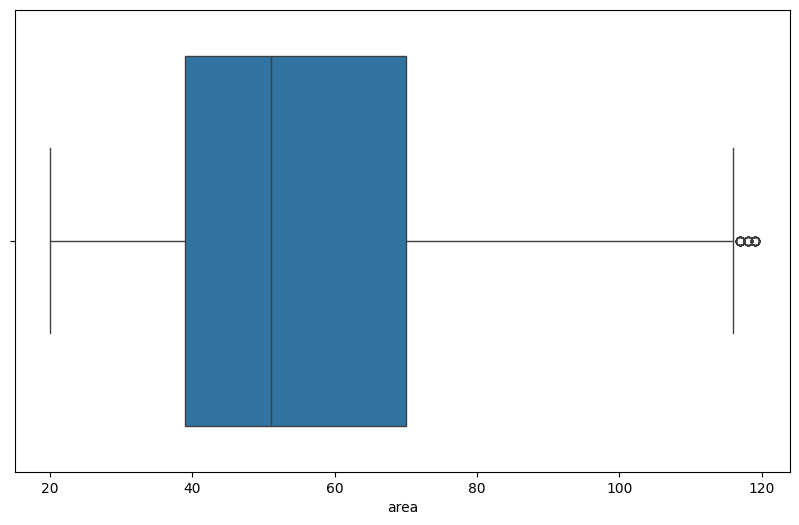

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])
df.area.describe()

### Engenharia de Features

### Removendo Coluna "rent"

In [12]:
df_clean = df.drop(columns=['rent','address'])

### Criando coluna "price_m2"

In [13]:
df_clean["price_m2"] = df_clean["total"] / df_clean["area"]
df_clean.price_m2.describe()

count    9294.000000
mean       60.371835
std        36.657964
min         9.650000
25%        36.808292
50%        50.782468
75%        73.335882
max      1112.916667
Name: price_m2, dtype: float64

### Criando coluna "price_level"

In [14]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "Medio", "Alto", "Muito Alto"]

df_clean["price_level"] = pd.cut(
    df_clean["price_m2"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

In [15]:
df_clean

,district,area,bedrooms,garage,type,total,price_m2,price_level
0,Belenzinho,21,1,0,Studio e kitnet,2939,139.952381,Muito Alto
3,Vila Ré,56,2,2,Casa em condomínio,1954,34.892857,Baixo
5,Brás,50,2,1,Apartamento,4587,91.740000,Muito Alto
6,Brooklin Paulista,72,2,1,Apartamento,5187,72.041667,Alto
7,Centro,26,1,0,Studio e kitnet,2244,86.307692,Alto
...,...,...,...,...,...,...,...,...
11645,Santo Amaro,70,2,0,Apartamento,3116,44.514286,Baixo
11652,Santo Amaro,94,2,1,Apartamento,5778,61.468085,Medio
11654,Jardim Caravelas,84,1,2,Apartamento,5467,65.083333,Medio
11655,Jardim Fonte do Morumbi,76,1,0,Apartamento,10200,134.210526,Muito Alto


### Distribuição de Imoveis Preço Total

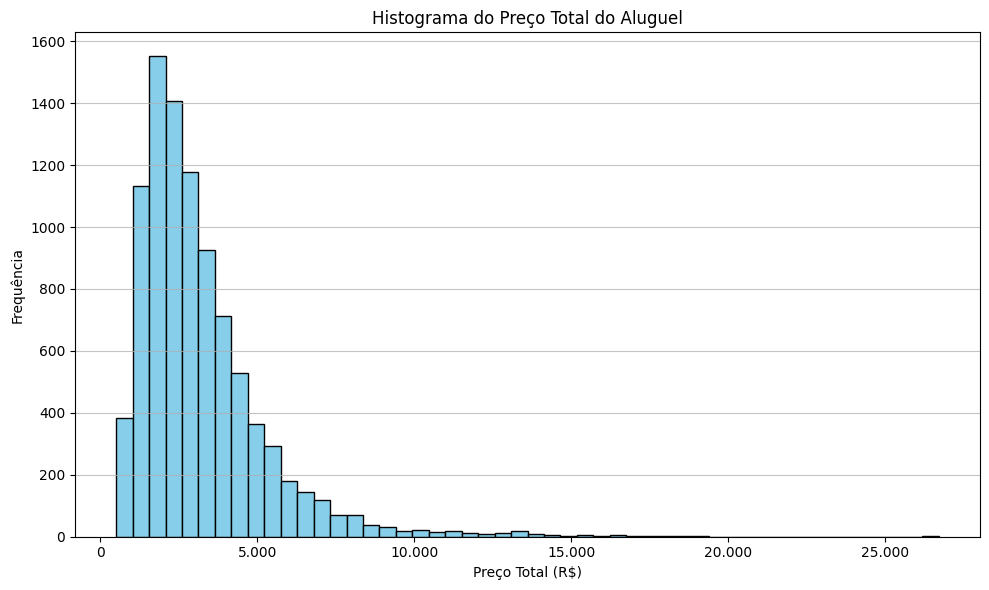

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_clean['total'], bins=50, color='skyblue', edgecolor='black')

ax.set_title('Histograma do Preço Total do Aluguel')
ax.set_xlabel('Preço Total (R$)')    # O eixo X é o preço
ax.set_ylabel('Frequência')          # O eixo Y é a contagem
ax.grid(axis='y', alpha=0.75)

# A formatação do eixo é um pouco diferente aqui
ax.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x).replace(",", "."))
)

# Ajusta o layout para garantir que nada seja cortado
plt.tight_layout()

### Distribuição de Imoveis Preço m2

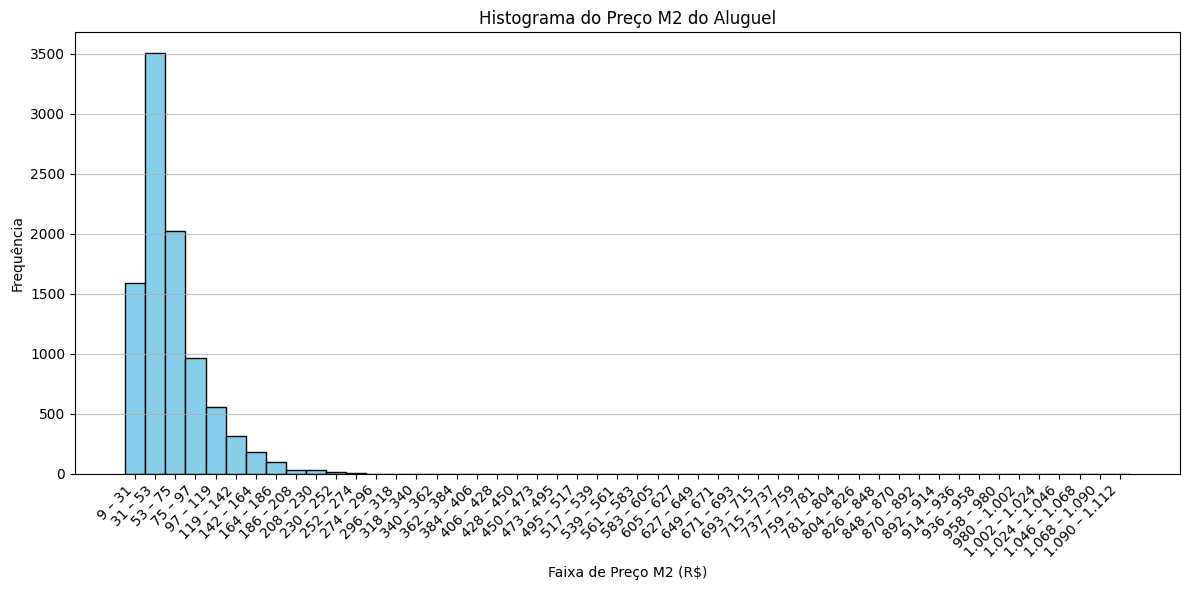

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

# Captura os dados do histograma
counts, bins, patches = ax.hist(
    df_clean['price_m2'], bins=50, color='skyblue', edgecolor='black'
)

# Criar rótulos de intervalo
bin_labels = [f"{int(bins[i]):,} – {int(bins[i+1]):,}".replace(",", ".")
              for i in range(len(bins)-1)]

# Definir ticks no centro de cada bin
bin_centers = (bins[:-1] + bins[1:]) / 2
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels, rotation=45, ha="right")

ax.set_title("Histograma do Preço M2 do Aluguel")
ax.set_xlabel("Faixa de Preço M2 (R$)")
ax.set_ylabel("Frequência")
ax.grid(axis="y", alpha=0.75)

plt.tight_layout()
plt.show()


Mapear bairros para cada faixa

In [18]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "Médio", "Alto", "Muito Alto"]

df_clean["faixa_preco_m2"] = pd.cut(df_clean["price_m2"], bins=bins, labels=labels, include_lowest=True)

# Contagem de imóveis por distrito dentro de cada faixa
concentracao = df_clean.groupby(["faixa_preco_m2", "district"]).size().reset_index(name="quantidade")

# Para cada faixa, pegar o distrito com maior concentração
top_distritos = concentracao.loc[concentracao.groupby("faixa_preco_m2")["quantidade"].idxmax()]

top_distritos


/tmp/ipykernel_32056/2679612559.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  concentracao = df_clean.groupby(["faixa_preco_m2", "district"]).size().reset_index(name="quantidade")
/tmp/ipykernel_32056/2679612559.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_distritos = concentracao.loc[concentracao.groupby("faixa_preco_m2")["quantidade"].idxmax()]


,faixa_preco_m2,district,quantidade
22,Baixo,Bela Vista,94
1110,Médio,Bela Vista,81
2198,Alto,Bela Vista,66
3866,Muito Alto,Pinheiros,93


### Analisando a relação entre Bairro e Nível de Preço

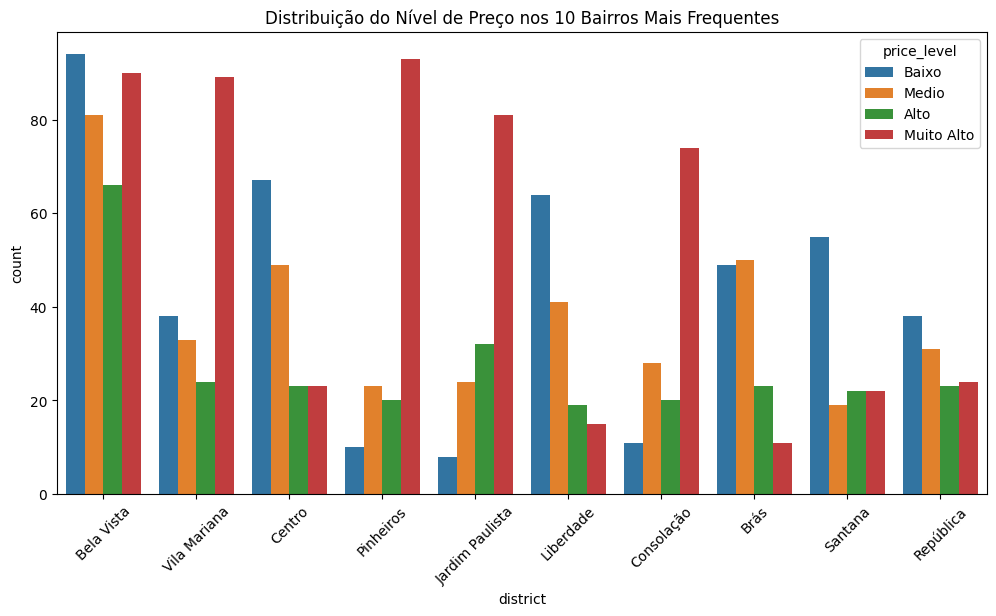

In [19]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x='district', hue='price_level', order=df_clean['district'].value_counts().iloc[:10].index)
plt.title('Distribuição do Nível de Preço nos 10 Bairros Mais Frequentes')
plt.xticks(rotation=45)
plt.show()

### Analisando a relação entre Tipo de Imóvel e Nível de Preço

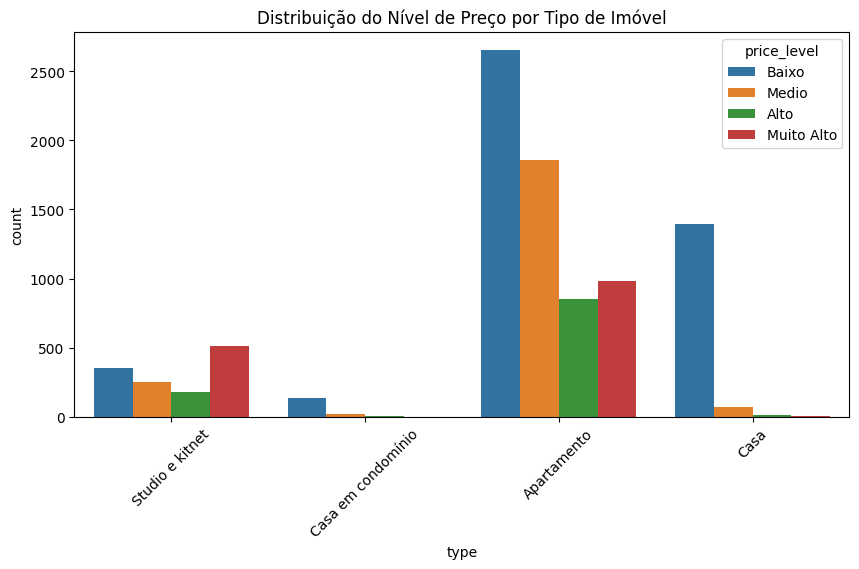

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x='type', hue='price_level')
plt.title('Distribuição do Nível de Preço por Tipo de Imóvel')
plt.xticks(rotation=45)
plt.show()

Mapa de correlação (heatmap) para identificar quais variáveis impactam mais no preço do aluguel.

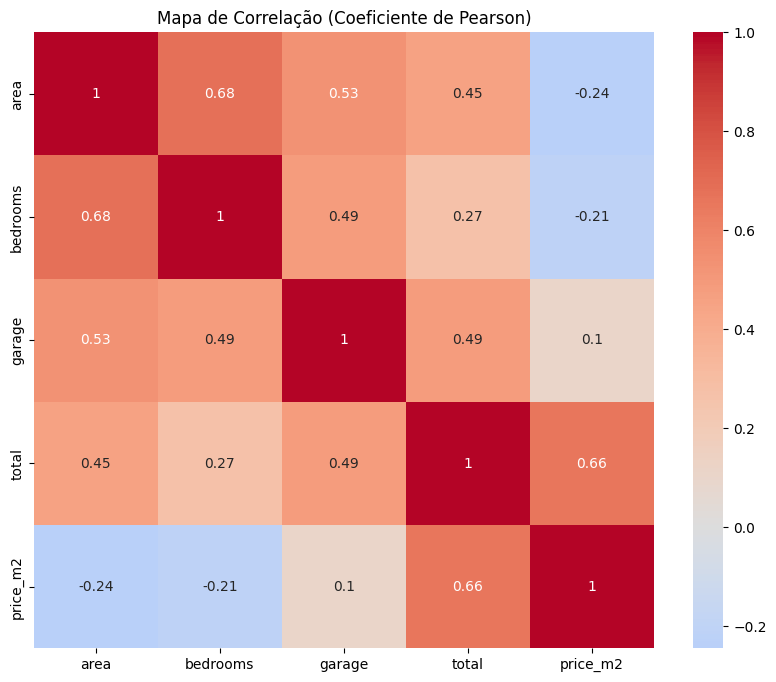

In [21]:
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"])

corr = numeric_cols.corr(method="pearson")

# Plotar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de Correlação (Coeficiente de Pearson)")
plt.show()


Clusterização de bairros
Usar KMeans ou DBSCAN para agrupar bairros com perfis semelhantes de aluguel/m².


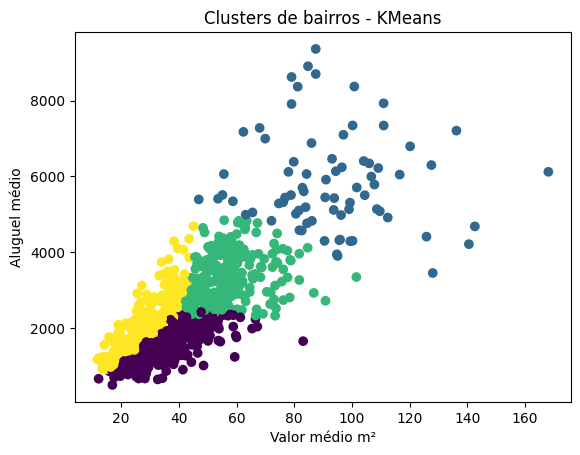

                                            district   price_m2        total  \
0                                          Aclimação  56.014841  3196.863636   
1                                           Adalgisa  79.082569  8620.000000   
2                                        Agua Branca  59.571429  2919.000000   
3                                         Alphaville  86.138020  4830.500000   
4  Alphaville Centro Industrial E Empresarial/alp...  61.016172  4187.333333   

         area  cluster_kmeans  cluster_dbscan  
0   61.636364               2               0  
1  109.000000               1               0  
2   49.000000               2               0  
3   57.000000               1               0  
4   69.666667               2               0  


In [22]:
bairros = df_clean.groupby("district").agg({
    "price_m2": "mean",
    "total": "mean",
    "area": "mean"
}).reset_index()

# 4. Selecionar features para clusterização
X = bairros[["price_m2", "total", "area"]]

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. KMeans
kmeans = KMeans(n_clusters=4, random_state=42)  # defina n_clusters
bairros["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

# 6. DBSCAN (parâmetros eps e min_samples ajustáveis)
dbscan = DBSCAN(eps=1.2, min_samples=3)
bairros["cluster_dbscan"] = dbscan.fit_predict(X_scaled)

# 7. Visualizar clusters (exemplo com 2 variáveis)
plt.scatter(bairros["price_m2"], bairros["total"],
            c=bairros["cluster_kmeans"], cmap="viridis")
plt.xlabel("Valor médio m²")
plt.ylabel("Aluguel médio")
plt.title("Clusters de bairros - KMeans")
plt.show()

print(bairros.head())

Comparar price_level entre imóveis com 1, 2, 3 e 4 quartos.

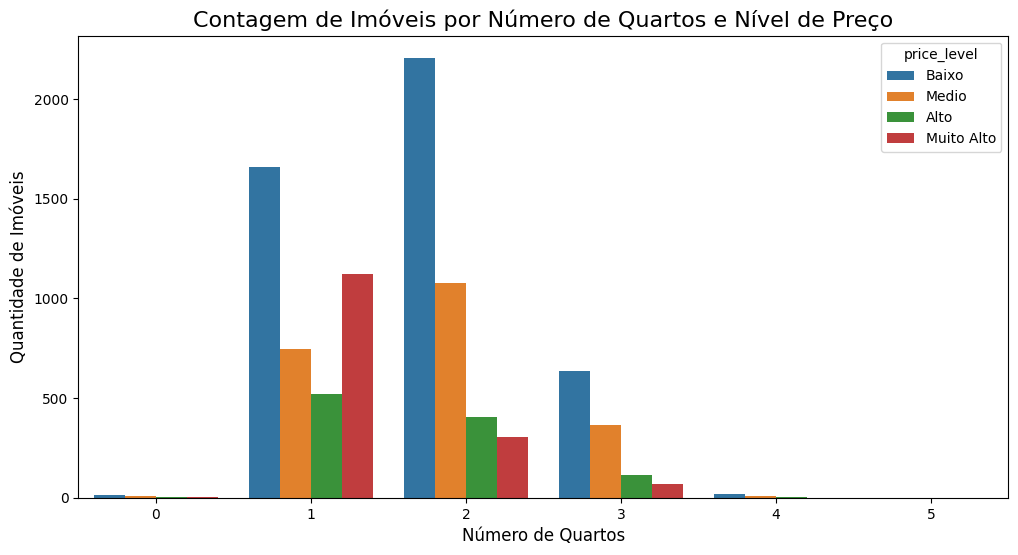

In [23]:
quartos_ordenados = sorted(df_clean['bedrooms'].unique())
quartos_ordenados = [q for q in quartos_ordenados if q <= 6] # Exemplo: limita até 6 quartos

plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_clean,
    x='bedrooms',
    hue='price_level',  # <<< CORREÇÃO: Usar a variável categórica 'price_level'
    order=quartos_ordenados # <<< Garante a ordem correta no eixo x
)

# Título corrigido para corresponder ao gráfico
plt.title('Contagem de Imóveis por Número de Quartos e Nível de Preço', fontsize=16)
plt.xlabel('Número de Quartos', fontsize=12)
plt.ylabel('Quantidade de Imóveis', fontsize=12)
plt.xticks(rotation=0) # Não precisa de rotação para poucos números
plt.show()

Impacto da vaga de garagem no preço/m².

In [24]:
df_garagem = df_clean.copy()

# Corrige a escala do preço/m² para Reais (R$)
df_garagem['price_m2'] = df_garagem['price_m2']

# Função para formatar o eixo Y como moeda
def format_currency(x, pos):
    return f'R$ {int(x):,}'.replace(',', '.')

formatter = FuncFormatter(format_currency)

# Para focar a análise, vamos ver a distribuição de vagas de garagem
print("--- Contagem de Imóveis por Número de Vagas ---")
print(df_garagem['garage'].value_counts())

--- Contagem de Imóveis por Número de Vagas ---
garage
1    4231
0    3887
2    1098
3      63
4       8
5       4
6       3
Name: count, dtype: int64


/tmp/ipykernel_32056/3281451334.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=preco_por_vaga, x='garage', y='price_m2', palette='viridis')


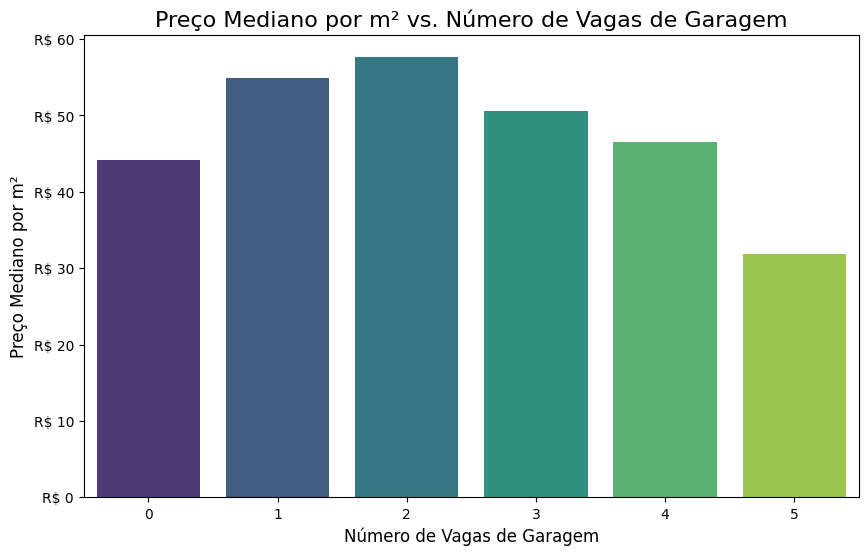


--- Preço Mediano por m² por Vaga de Garagem ---
   garage   price_m2
0       0  44.192308
1       1  54.951613
2       2  57.627037
3       3  50.520000
4       4  46.585885
5       5  31.881978


In [25]:
vagas_comuns = [0, 1, 2, 3, 4, 5]
df_filtrado_vagas = df_garagem[df_garagem['garage'].isin(vagas_comuns)]

# Agrupar por número de vagas e calcular a mediana do preço/m²
preco_por_vaga = df_filtrado_vagas.groupby('garage')['price_m2'].median().reset_index()

# Visualização com Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=preco_por_vaga, x='garage', y='price_m2', palette='viridis')

plt.title('Preço Mediano por m² vs. Número de Vagas de Garagem', fontsize=16)
plt.xlabel('Número de Vagas de Garagem', fontsize=12)
plt.ylabel('Preço Mediano por m²', fontsize=12)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

# Imprimir a tabela para referência
print("\n--- Preço Mediano por m² por Vaga de Garagem ---")
print(preco_por_vaga)

#### Removendo linhas com NaN na feature target

In [26]:
df_clean = df_clean.dropna(subset=["price_level"])

In [27]:
df_clean

,district,area,bedrooms,garage,type,total,price_m2,price_level,faixa_preco_m2
0,Belenzinho,21,1,0,Studio e kitnet,2939,139.952381,Muito Alto,Muito Alto
3,Vila Ré,56,2,2,Casa em condomínio,1954,34.892857,Baixo,Baixo
5,Brás,50,2,1,Apartamento,4587,91.740000,Muito Alto,Muito Alto
6,Brooklin Paulista,72,2,1,Apartamento,5187,72.041667,Alto,Alto
7,Centro,26,1,0,Studio e kitnet,2244,86.307692,Alto,Alto
...,...,...,...,...,...,...,...,...,...
11645,Santo Amaro,70,2,0,Apartamento,3116,44.514286,Baixo,Baixo
11652,Santo Amaro,94,2,1,Apartamento,5778,61.468085,Medio,Médio
11654,Jardim Caravelas,84,1,2,Apartamento,5467,65.083333,Medio,Médio
11655,Jardim Fonte do Morumbi,76,1,0,Apartamento,10200,134.210526,Muito Alto,Muito Alto


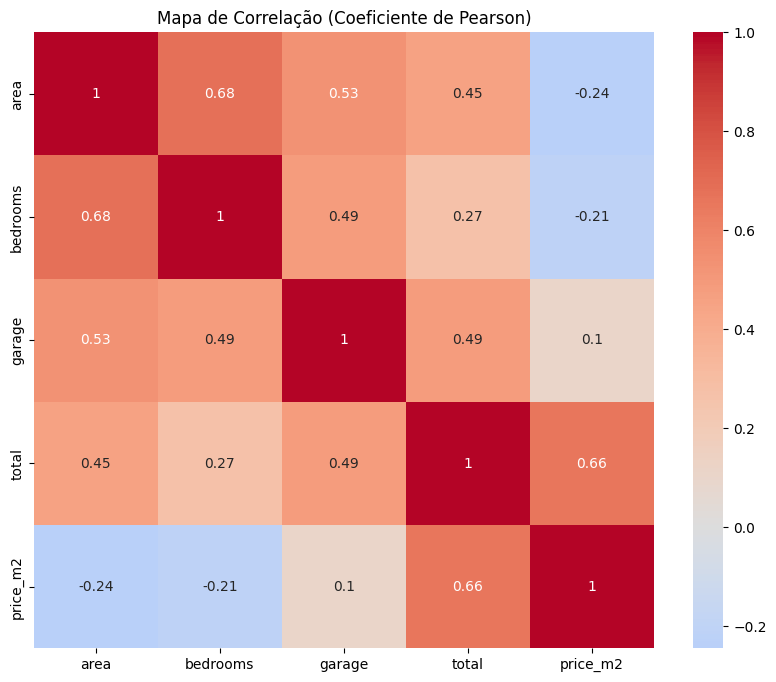

In [28]:

numeric_cols = df_clean.select_dtypes(include=["int64", "float64"])

corr = numeric_cols.corr(method="pearson")

# Plotar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de Correlação (Coeficiente de Pearson)")
plt.show()


#### Verificando a distribuição

price_level
Baixo         4537
Medio         2209
Muito Alto    1500
Alto          1048
Name: count, dtype: int64


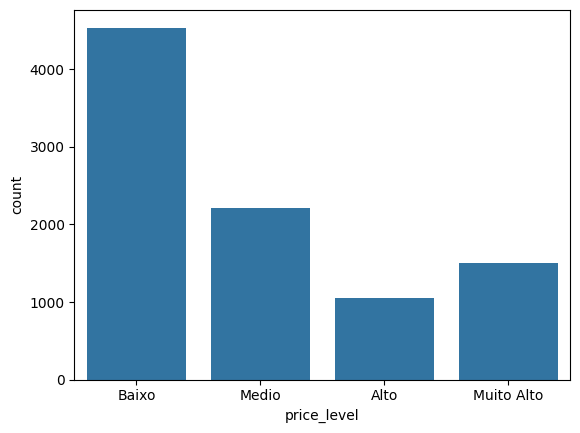

In [29]:
sns.countplot(x = df_clean['price_level'])
print(df_clean["price_level"].value_counts())

Balanceando dataset

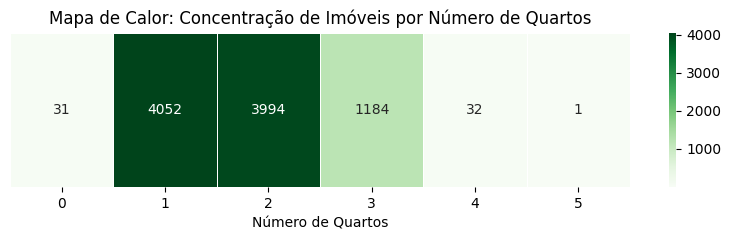

In [30]:
bedroom_counts = df_clean['bedrooms'].value_counts().reset_index()
bedroom_counts.columns = ['bedrooms', 'count']
bedroom_counts = bedroom_counts.sort_values('bedrooms')

heatmap_1d_data = bedroom_counts.set_index('bedrooms').T

# Gerando o mapa de calor 1D
plt.figure(figsize=(10, 2))
sns.heatmap(heatmap_1d_data, cmap="Greens", annot=True, fmt=".0f", linewidths=.5)
plt.title('Mapa de Calor: Concentração de Imóveis por Número de Quartos')
plt.xlabel('Número de Quartos')
plt.ylabel('')
plt.yticks([])
plt.savefig('heatmap_imoveis_apenas_quartos.png') # Salva a imagem
plt.show()

## Divisão entre previsores (X) e classe (y)

In [31]:
target = "price_level"
X = df_clean.drop(columns=[target, 'price_m2', 'total','faixa_preco_m2'])
y = df_clean[target]

print("Features utilizadas para o treinamento:", X.columns.tolist())

Features utilizadas para o treinamento: ['district', 'area', 'bedrooms', 'garage', 'type']


#### Separando variaveis entre numericas e categoricas

In [58]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [ ]:
num_features = ["area"]
cat_features.extend(['garage',"bedrooms"])
cat_features

AttributeError: 'list' object has no attribute 'add'

##  Escalonamento dos valores e Codificação de variáveis categóricas

### Criando pipeline de Transformer

In [43]:
# Normalizando as variaveis Numericas

# Se ainda tiver valores ausentes é aplicado a estrategia de Mediana
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Transformando variaveis categoricas em numericas atraves do OneHotEncoder

# Se ainda tiver valores ausentes é aplicado a estrategia de Moda
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

## Divisão da Base em treinamento, teste

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

###  Transformer para converter sparse -> dense (para Naive Bayes)

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.toarray()

## Invocando modelos

In [47]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "SVM": SVC(class_weight="balanced", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "NeuralNetwork": MLPClassifier(max_iter=500, random_state=42), # Demora muito...trava computador
    "NaiveBayes": GaussianNB()
}

### Dataset de avaliação de modelos

In [48]:
resultados = []

### Treinamento e validação

In [49]:
# --- 1. INICIE AS VARIÁVEIS DE CONTROLE ANTES DO LOOP ---
melhor_pipeline = None
nome_melhor_modelo = ""
melhor_score = 0.0 # Começamos com uma pontuação de 0

# (O resto do seu código de treinamento)
# ...

for name, model in models.items():
    print(f"\n==================== {name} ====================")

    # Cria um pipeline completo para cada modelo
    if name == "NaiveBayes":
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('to_dense', DenseTransformer()),
            ('tomek', TomekLinks(sampling_strategy='auto')),
            # ('smote', SMOTE(random_state=42)), # SMOTE continua comentado
            ('classifier', model)
        ])
    else:
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            # ('tomek', TomekLinks(sampling_strategy='auto')),
            ('smote', SMOTE(random_state=42)), # SMOTE continua comentado
            ('classifier', model)
        ])

    # Treinamento
    inicio = time.time()
    pipeline.fit(X_train, y_train)
    fim = time.time()
    tempo_treino = fim - inicio

    # Previsões
    y_pred_test = pipeline.predict(X_test)

    # Métricas
    acc_test = accuracy_score(y_test, y_pred_test)

    # --- 2. VERIFICA SE O MODELO ATUAL É O MELHOR ATÉ AGORA ---
    if acc_test > melhor_score:
        print(f"✨ Novo melhor modelo encontrado: {name} com acurácia de {acc_test:.4f}!")
        melhor_score = acc_test
        melhor_pipeline = pipeline  # Guarda o objeto do pipeline inteiro
        nome_melhor_modelo = name

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão - {name}')
    plt.show()

    # Relatório de Classificação
    print(f"\nRelatório de Classificação para {name}:")
    print(classification_report(y_test, y_pred_test, target_names=labels))
    print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")
    print("=" * 52)

    resultados.append({
        "Modelo": name,
        "Acurácia Teste": acc_test,
        "Tempo Treino (s)": round(tempo_treino, 4)
    })


==================== LogisticRegression ====================


TypeError: unhashable type: 'list'

### Exibindo Resultados

In [ ]:
df_resultados = pd.DataFrame(resultados)
df_resultados

,Modelo,Acurácia Teste,Tempo Treino (s)
0,LogisticRegression,0.598171,1.4952
1,RandomForest,0.608392,10.7665
2,SVM,0.593330,34.5461
3,KNN,0.395912,0.1591
4,DecisionTree,0.596557,0.6303
5,NeuralNetwork,0.610005,89.4246
6,NaiveBayes,0.346423,1.1521


## Salvando Transformers e modelo

In [ ]:
if melhor_pipeline is not None:
    joblib.dump(melhor_pipeline, f"{nome_melhor_modelo}.pkl")
    print(f"\n✅ Melhor modelo ('{nome_melhor_modelo}') foi salvo no arquivo '{nome_melhor_modelo}.pkl'")
    print(f"   Acurácia no teste: {melhor_score:.4f}")
else:
    print("\n❌ Nenhum modelo foi treinado ou salvo.")


✅ Melhor modelo ('NeuralNetwork') foi salvo no arquivo 'NeuralNetwork.pkl'
   Acurácia no teste: 0.6100



==================== LogisticRegression (com PCA) ====================


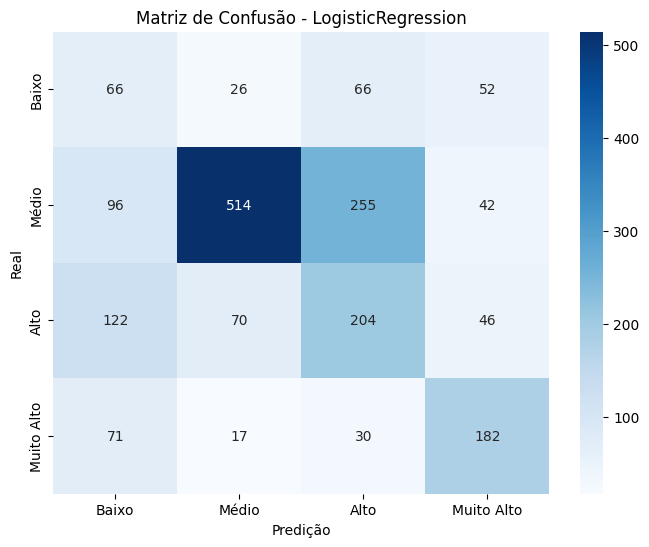


Relatório de Classificação para LogisticRegression:
              precision    recall  f1-score   support

       Baixo       0.19      0.31      0.23       210
       Médio       0.82      0.57      0.67       907
        Alto       0.37      0.46      0.41       442
  Muito Alto       0.57      0.61      0.59       300

    accuracy                           0.52      1859
   macro avg       0.48      0.49      0.47      1859
weighted avg       0.60      0.52      0.55      1859

Tempo de treinamento: 3.4537 segundos

==================== RandomForest (com PCA) ====================
✨ Novo melhor modelo encontrado: RandomForest com acurácia de 0.6122!


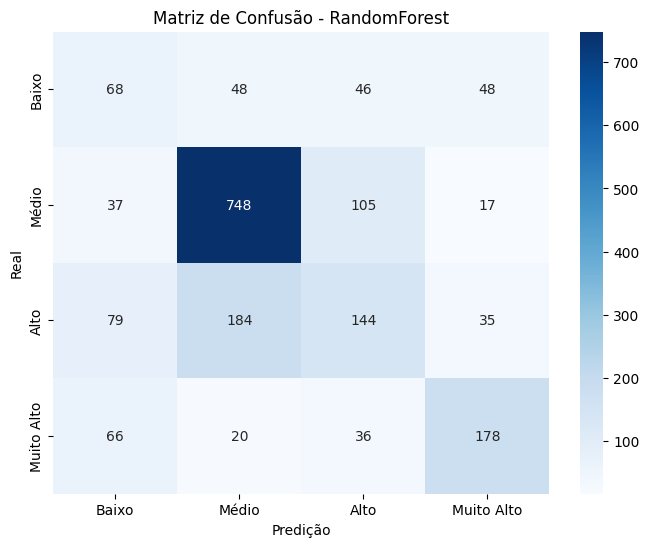


Relatório de Classificação para RandomForest:
              precision    recall  f1-score   support

       Baixo       0.27      0.32      0.30       210
       Médio       0.75      0.82      0.78       907
        Alto       0.44      0.33      0.37       442
  Muito Alto       0.64      0.59      0.62       300

    accuracy                           0.61      1859
   macro avg       0.52      0.52      0.52      1859
weighted avg       0.60      0.61      0.60      1859

Tempo de treinamento: 9.1161 segundos

==================== SVM (com PCA) ====================


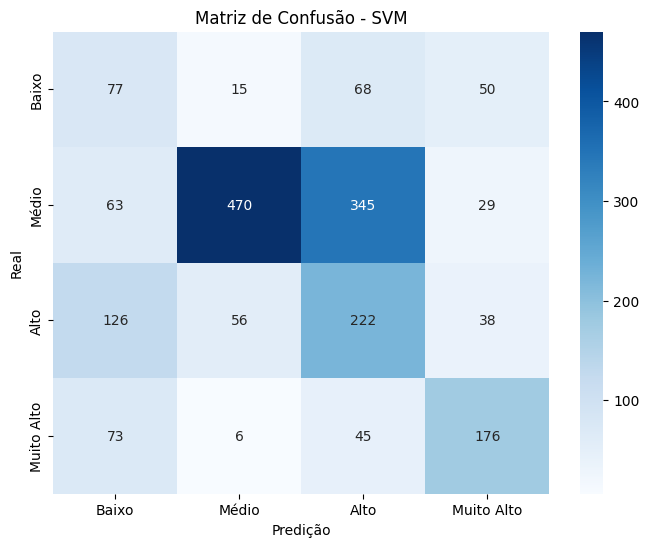


Relatório de Classificação para SVM:
              precision    recall  f1-score   support

       Baixo       0.23      0.37      0.28       210
       Médio       0.86      0.52      0.65       907
        Alto       0.33      0.50      0.40       442
  Muito Alto       0.60      0.59      0.59       300

    accuracy                           0.51      1859
   macro avg       0.50      0.49      0.48      1859
weighted avg       0.62      0.51      0.54      1859

Tempo de treinamento: 15.0072 segundos

==================== KNN (com PCA) ====================


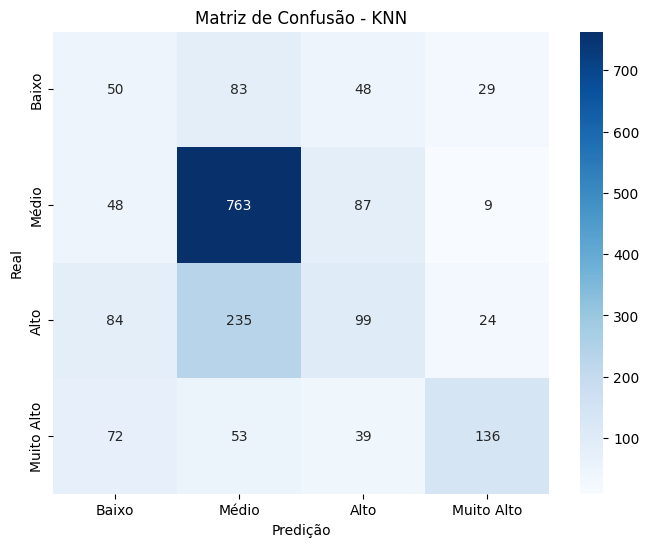


Relatório de Classificação para KNN:
              precision    recall  f1-score   support

       Baixo       0.20      0.24      0.22       210
       Médio       0.67      0.84      0.75       907
        Alto       0.36      0.22      0.28       442
  Muito Alto       0.69      0.45      0.55       300

    accuracy                           0.56      1859
   macro avg       0.48      0.44      0.45      1859
weighted avg       0.55      0.56      0.54      1859

Tempo de treinamento: 0.5155 segundos

==================== DecisionTree (com PCA) ====================


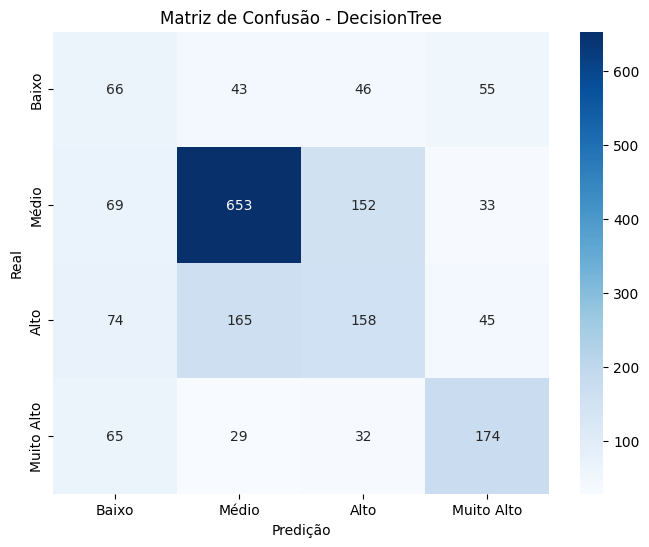


Relatório de Classificação para DecisionTree:
              precision    recall  f1-score   support

       Baixo       0.24      0.31      0.27       210
       Médio       0.73      0.72      0.73       907
        Alto       0.41      0.36      0.38       442
  Muito Alto       0.57      0.58      0.57       300

    accuracy                           0.57      1859
   macro avg       0.49      0.49      0.49      1859
weighted avg       0.57      0.57      0.57      1859

Tempo de treinamento: 1.5397 segundos

==================== NeuralNetwork (com PCA) ====================


/home/botero/Documents/POS/F_machine_learning/projeto/imoveis-sp-prediction/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


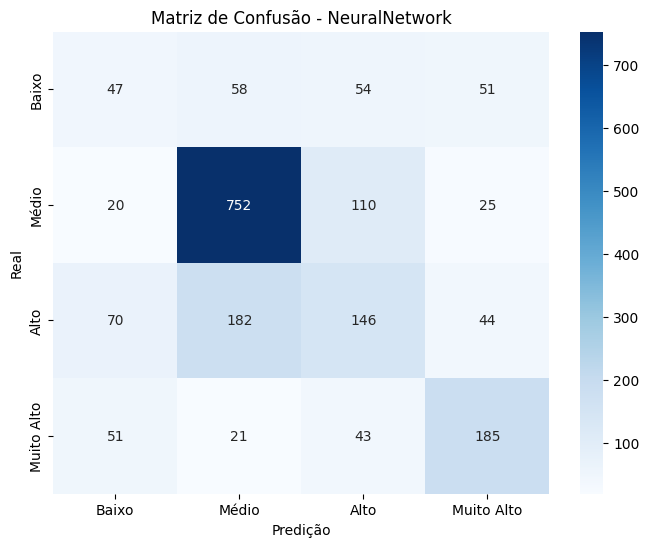


Relatório de Classificação para NeuralNetwork:
              precision    recall  f1-score   support

       Baixo       0.25      0.22      0.24       210
       Médio       0.74      0.83      0.78       907
        Alto       0.41      0.33      0.37       442
  Muito Alto       0.61      0.62      0.61       300

    accuracy                           0.61      1859
   macro avg       0.50      0.50      0.50      1859
weighted avg       0.59      0.61      0.59      1859

Tempo de treinamento: 16.9311 segundos

==================== NaiveBayes (com PCA) ====================


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [ ]:
# from sklearn.decomposition import PCA

# for name, model in models.items():
#     print(f"\n==================== {name} (com PCA) ====================")

#     # Adicionamos o passo ('pca', PCA(...)) ao pipeline
#     if name == "NaiveBayes":
#         pipeline = ImbPipeline(steps=[
#             ('preprocessor', preprocessor),
#             ('svd', TruncatedSVD(n_components=100)),
#             ('to_dense', DenseTransformer()),
#             ('tomek', TomekLinks(sampling_strategy='auto')),
#             ('classifier', model)
#         ])
#     else:
#         pipeline = ImbPipeline(steps=[
#             ('preprocessor', preprocessor),
#             ('svd', TruncatedSVD(n_components=100)),
#             ('tomek', TomekLinks(sampling_strategy='auto')),
#             ('classifier', model)
#         ])

#     # Treinamento
#     inicio = time.time()
#     pipeline.fit(X_train, y_train)
#     fim = time.time()
#     tempo_treino = fim - inicio

#     # Previsões
#     y_pred_test = pipeline.predict(X_test)

#     # Métricas
#     acc_test = accuracy_score(y_test, y_pred_test)

#     # --- 2. VERIFICA SE O MODELO ATUAL É O MELHOR ATÉ AGORA ---
#     if acc_test > melhor_score:
#         print(f"✨ Novo melhor modelo encontrado: {name} com acurácia de {acc_test:.4f}!")
#         melhor_score = acc_test
#         melhor_pipeline = pipeline  # Guarda o objeto do pipeline inteiro
#         nome_melhor_modelo = name

#     # Matriz de Confusão
#     cm = confusion_matrix(y_test, y_pred_test)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=labels, yticklabels=labels)
#     plt.xlabel('Predição')
#     plt.ylabel('Real')
#     plt.title(f'Matriz de Confusão - {name}')
#     plt.show()

#     # Relatório de Classificação
#     print(f"\nRelatório de Classificação para {name}:")
#     print(classification_report(y_test, y_pred_test, target_names=labels))
#     print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")
#     print("=" * 52)

#     resultados.append({
#         "Modelo": name,
#         "Acurácia Teste": acc_test,
#         "Tempo Treino (s)": round(tempo_treino, 4)
#     })

In [ ]:
df_resultados = pd.DataFrame(resultados)
df_resultados

,Modelo,Acurácia Teste,Tempo Treino (s)
0,LogisticRegression,0.598709,2.9328
1,RandomForest,0.611619,12.5105
2,SVM,0.594406,35.0141
3,KNN,0.396450,0.1600
4,DecisionTree,0.596019,0.5055
5,NeuralNetwork,0.599785,49.7783
6,NaiveBayes,0.346423,3.3183
7,LogisticRegression,0.517483,2.4451
8,RandomForest,0.621840,7.3641
9,SVM,0.507800,13.1417


In [ ]:
if melhor_pipeline is not None:
    joblib.dump(melhor_pipeline, f"{nome_melhor_modelo}_pca.pkl")
    print(f"\n✅ Melhor modelo ('{nome_melhor_modelo}') foi salvo no arquivo '{nome_melhor_modelo}_pca.pkl'")
    print(f"   Acurácia no teste: {melhor_score:.4f}")
else:
    print("\n❌ Nenhum modelo foi treinado ou salvo.")


✅ Melhor modelo ('RandomForest') foi salvo no arquivo 'RandomForest_pca.pkl'
   Acurácia no teste: 0.6218
